In [6]:
# Load dataset from image database and return numpy arrays

import numpy as np
import os
import random
from PIL import Image, ImageOps

TRAIN_DIR = './dataset/training_set'
TEST_DIR = './dataset/test_set'
CATEGORIES = ['dogs', 'cats']



def get_training_data(size=64):
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR, category) # Path to cats or dogs dir
        for img_name in os.listdir(path):
            if img_name.endswith('.jpg'):
                img = Image.open(os.path.join(path, img_name))
                img = ImageOps.fit(img, (size, size))
                training_data.append([np.array(img), CATEGORIES.index(category)])
            
    random.shuffle(training_data)
    
    train_set_x = []
    train_set_y = []
    for features, label in training_data:
        train_set_x.append(features)
        train_set_y.append(label)
        
    train_set_x = np.array(train_set_x)
    train_set_y = np.array(train_set_y)
    train_set_y = train_set_y.reshape(1, train_set_y.shape[0])
    
    return train_set_x, train_set_y



def get_test_data(size=64):
    test_data = []
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR, category)
        for img_name in os.listdir(path):
            if img_name.endswith('.jpg'):
                img = Image.open(os.path.join(path, img_name))
                img = ImageOps.fit(img, (size, size))
                test_data.append([np.array(img), CATEGORIES.index(category)])
                
    random.shuffle(test_data)
    
    test_set_x = []
    test_set_y = []
    for features, label in test_data:
        test_set_x.append(features)
        test_set_y.append(label)
        
    test_set_x = np.array(test_set_x)
    test_set_y = np.array(test_set_y)
    test_set_y = test_set_y.reshape(1, test_set_y.shape[0])
    
    return test_set_x, test_set_y



def get_data(size=64):
    train_set_x, train_set_y = get_training_data(size)
    test_set_x, test_set_y = get_test_data(size)
    return train_set_x, train_set_y, test_set_x, test_set_y

In [7]:
# Preprocess out data

train_set_x, train_set_y, test_set_x, test_set_y = get_data()
m_train = train_set_x.shape[0]
m_test = test_set_x.shape[0]

# Flatten image matrix data
# To flatten a matrix X of shape (a,b, c, d) to (b*c*d, a),
# use X_flatten = X.reshape(X.shape[0], -1).T
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

# Center and standardize our dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

Number of training examples: m_train = 8005
Number of testing examples: m_test = 2023
train_set_x shape: (8005, 64, 64, 3)
train_set_y shape: (1, 8005)
test_set_x shape: (2023, 64, 64, 3)
test_set_y shape: (1, 2023)
train_set_x_flatten shape: (12288, 8005)
test_set_x_flatten shape: (12288, 2023)


In [8]:
# Algorithms

# Formulas:
# z = w.T * x + b
# y = a = sigmoid(z)
# L(a, y) = -ylog(a) - (1-y)log(1-a)
# J(w, b) = 1/m * sum(L(a, y))
# dw = dJ/dw = 1/m * X(A - Y).T
# db = dJ/dB = 1/m * sum(a - y)

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s



def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b



def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1/m) * np.sum((Y * np.log(A)) + (1 - Y) * np.log(1 - A), axis=1)
    
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost



def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs



def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    
    return Y_prediction



def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

learning rate is: 0.001
train accuracy: 63.56027482823235 %
test accuracy: 59.76272862086011 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 59.63772642098688 %
test accuracy: 59.268413247652 %

-------------------------------------------------------

learning rate is: 1e-05
train accuracy: 57.40162398500937 %
test accuracy: 58.13148788927336 %

-------------------------------------------------------

learning rate is: 1e-06
train accuracy: 56.402248594628354 %
test accuracy: 56.20365793376174 %

-------------------------------------------------------



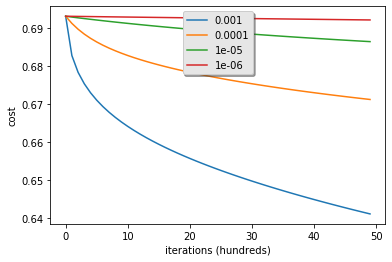

In [4]:
import matplotlib.pyplot as plt

# Training of model with different learning rates
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
models = {}
for i in learning_rates:
    print('learning rate is: ' + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')
    
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))
    
# Plotting of graph
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [14]:
# From above result, learning rate of 0.001 is best, though it is overfitted

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.682797
Cost after iteration 200: 0.678384
Cost after iteration 300: 0.675370
Cost after iteration 400: 0.673013
Cost after iteration 500: 0.671050
Cost after iteration 600: 0.669357
Cost after iteration 700: 0.667860
Cost after iteration 800: 0.666512
Cost after iteration 900: 0.665281
Cost after iteration 1000: 0.664146
Cost after iteration 1100: 0.663089
Cost after iteration 1200: 0.662099
Cost after iteration 1300: 0.661165
Cost after iteration 1400: 0.660280
Cost after iteration 1500: 0.659437
Cost after iteration 1600: 0.658632
Cost after iteration 1700: 0.657860
Cost after iteration 1800: 0.657118
Cost after iteration 1900: 0.656402
Cost after iteration 2000: 0.655710
Cost after iteration 2100: 0.655041
Cost after iteration 2200: 0.654391
Cost after iteration 2300: 0.653759
Cost after iteration 2400: 0.653144
Cost after iteration 2500: 0.652545
Cost after iteration 2600: 0.651961
Cost after iteration 2700: 0.651390
Cost

In [26]:
# Final test

cat_img = Image.open('./cat_final_test.jpeg')
cat_img = ImageOps.fit(cat_img, (64, 64))
dog_img = Image.open('./dog_final_test.jpg')
dog_img = ImageOps.fit(dog_img, (64, 64))

cat_arr = np.array(cat_img)
cat_arr = cat_arr.reshape((1, 64*64*3)).T
cat_arr = cat_arr / 255.
dog_arr = np.array(dog_img)
dog_arr = dog_arr.reshape((1, 64*64*3)).T
dog_arr = dog_arr / 255.

my_predicted_image_of_cat = predict(d["w"], d["b"], cat_arr)
my_predicted_image_of_dog = predict(d["w"], d["b"], dog_arr)

print("y = " + str(np.squeeze(my_predicted_image_of_cat)))
print("y = " + str(np.squeeze(my_predicted_image_of_dog)))

# test cases failed..!!  :-( 
# but got to learn to create simple logistic regression

y = 0.0
y = 1.0
